In [1]:
from keras.applications import MobileNet

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224,224 
# pre trained weights : create my model
model = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [3]:
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

In [4]:
def layeradding(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
num_classes = 2

FC_Head = layeradding(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/validation/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 292 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [7]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("myMobileNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 292
nb_validation_samples = 48

# We only train 5 EPOCHS 
epochs = 5
batch_size = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    shuffle=True,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
43/58 [=====================>........] - ETA: 5:38 - loss: 2.1718 - accuracy: 0.7152

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 1486s 26s/step - loss: 1.8133 - accuracy: 0.7595 - val_loss: 0.0403 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.04029, saving model to myMobileNet.h5
Epoch 2/5
10/58 [====>.........................] - ETA: 21:17 - loss: 0.3352 - accuracy: 0.8904

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/58 [=====>........................] - ETA: 21:47 - loss: 0.3114 - accuracy: 0.8933

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/58 [==============>...............] - ETA: 14:16 - loss: 0.3229 - accuracy: 0.8933

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/58 [====================>.........] - ETA: 8:38 - loss: 0.4114 - accuracy: 0.8742

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/58 [========================>.....] - ETA: 4:15 - loss: 0.4467 - accuracy: 0.8795

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/58 [==========================>...] - ETA: 2:38 - loss: 0.4274 - accuracy: 0.8835

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 2090s 36s/step - loss: 0.3997 - accuracy: 0.8892 - val_loss: 0.0015 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.04029 to 0.00145, saving model to myMobileNet.h5
Epoch 3/5
 4/58 [=>............................] - ETA: 12:18 - loss: 0.1023 - accuracy: 0.9531

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 1574s 27s/step - loss: 0.3414 - accuracy: 0.9161 - val_loss: 0.0044 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00145
Epoch 4/5
 9/58 [===>..........................] - ETA: 12:06 - loss: 0.9496 - accuracy: 0.9115

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 1412s 24s/step - loss: 0.4238 - accuracy: 0.9384 - val_loss: 0.0189 - val_accuracy: 0.9615

Epoch 00004: val_loss did not improve from 0.00145
Epoch 5/5
58/58 [==============================] - 1367s 24s/step - loss: 0.2602 - accuracy: 0.9331 - val_loss: 4.8540e-06 - val_accuracy: 1.0000

Epoch 00005: val_loss improved from 0.00145 to 0.00000, saving model to myMobileNet.h5


In [8]:
from keras.models import load_model
classifier = load_model('myMobileNet.h5')

In [17]:
import cv2
import numpy as np
myimage_dict = {"[0]": "shruti", 
                "[1]": "yash"}
myimage_dict_n = {"n0": "shruti", 
                  "n1": "yash"}
def draw_test(name, pred, im):
    my = myimage_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, my, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)
# cap = cv2.VideoCapture('https://192.168.43.123:8080/video')
# cap = cv2.VideoCapture(0)
# ret , photo = cap.read()
photo = cv2.imread('test.jpg')
cv2.imshow('Image capturing',photo)
input_im = cv2.resize(photo, (224, 224))
input_im = input_im / 255.
input_im = input_im.reshape(1,224,224,3)
# Get Prediction
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
# Show image with predicted class
draw_test("Prediction", res, photo) 
cv2.waitKey(0)
cv2.destroyAllWindows()
#cap.release()

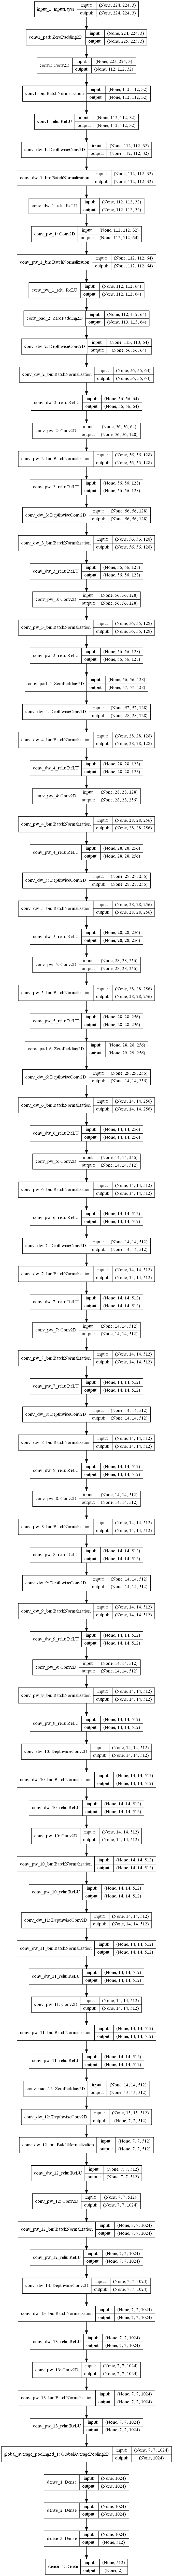

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='model_plot_MobileNet.png', show_shapes=True, show_layer_names=True)

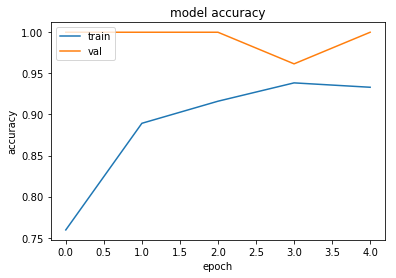

In [13]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

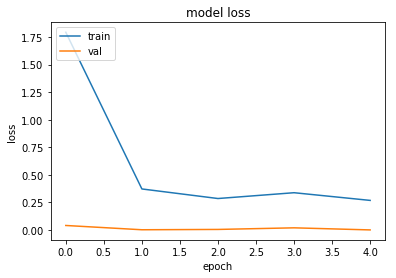

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()